### Spike-field analysis example
In this example we show how to perform spike-field analyses using `pylabianca` and `mne` ([MNE-Python](https://mne.tools/stable/index.html)).

In [35]:
import os
import os.path as op

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mne
import pylabianca as pln

### Reading LFP data 
We will first download example FieldTrip plexon nex (NeuroExplorer) data. These data are provided as part of a [FieldTrip spike-field tutorial](https://www.fieldtriptoolbox.org/tutorial/intracranial/spikefield/). We can download the data with `pylabianca.utils.get_fieldtrip_data`:

In [2]:
data_path = pln.utils.get_fieldtrip_data()

The data are downloaded to your user directory by default:

In [3]:
data_path

'C:\\Users\\Asus\\pylabianca_data\\p029_sort_final_01.nex'

Then we will use `pylabianca.io.read_signal_plexon_nex()` to read the continuous signal traces as mne Raw objects:

In [4]:
raw = pln.io.read_signal_plexon_nex(data_path)

Creating RawArray with float64 data, n_channels=6, n_times=7555983
    Range : 179 ... 7556161 =      0.179 ...  7556.161 secs
Ready.


We can inspect these data below. We set the browser backend to matplotlib temporarily, so that the figure is saved in the notebook and not opened intervactively.

Using matplotlib as 2D backend.


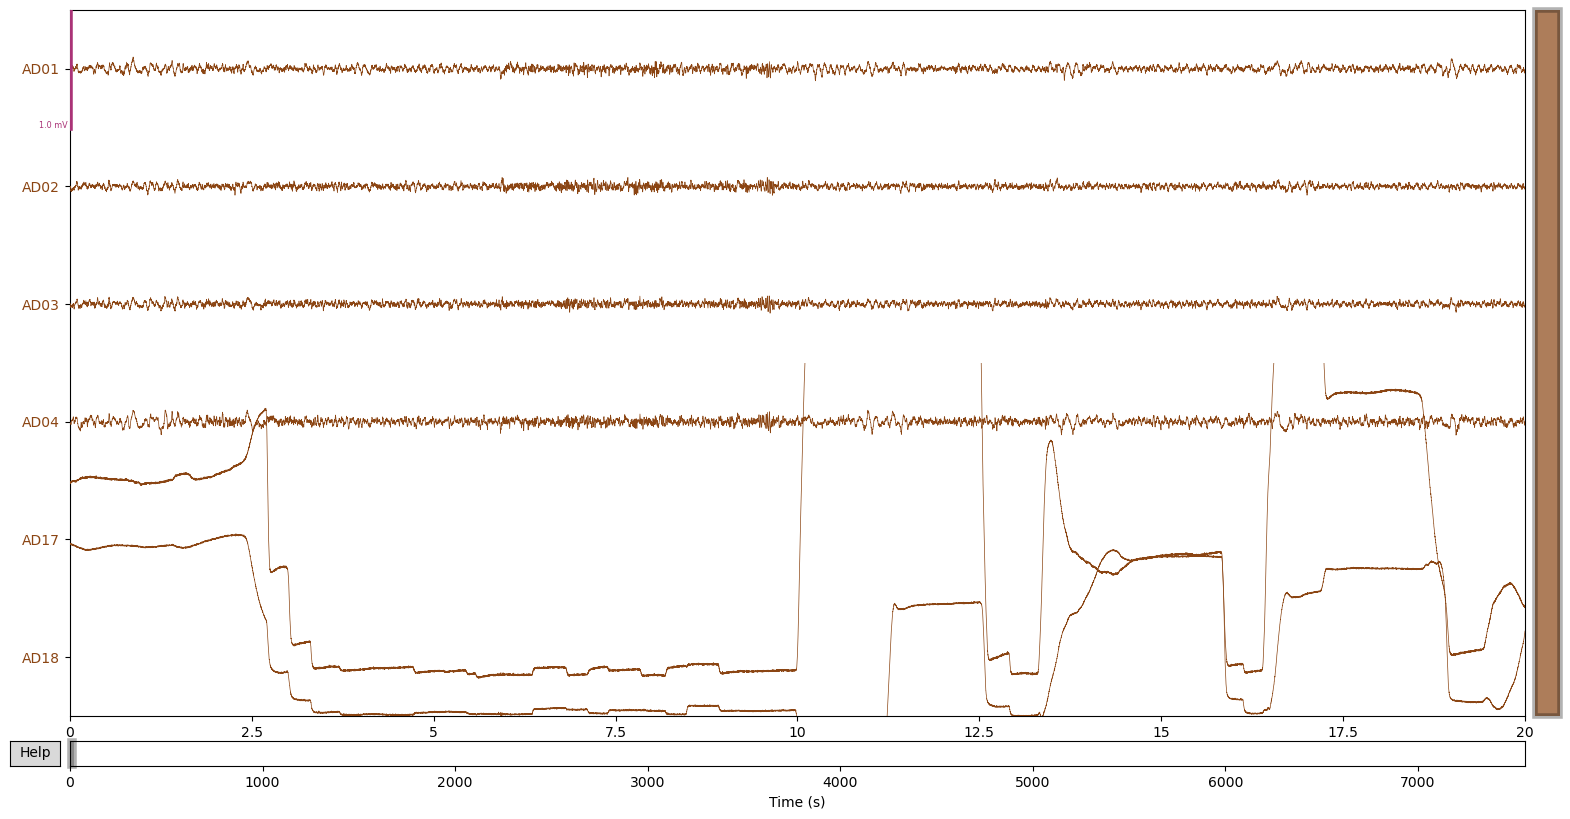

In [5]:
with mne.viz.use_browser_backend('matplotlib'):
    raw.plot(duration=20., scalings=5e-4);

We see that the first four channels contain LFP signals, but the last two - EOG. We could specify this in the `raw` object using `.set_channel_types()` method, but we will leave it this way for now.  

BTW for some reason mne's `set_browser_backend()` and `use_browser_backend()` mess up matplotlib's inline mode, so we call that mode again:

In [29]:
%matplotlib inline

### Read and epoch spikes
Now we will:
* read spikes data and the corresponding events
* epoch spike data with respect to stimulus presentation
* create new events with timestamps converted to LFP samples
* use these new events to epoch the raw signal with respect to the same events as the spike data

First we read in the spikes and the events:

In [6]:
spk = pln.io.read_plexon_nex(data_path)
events = pln.io.read_events_plexon_nex(data_path, format='mne')

for the purpose of this tutorial we will select only those cells that have waveforms (these are single-units, as opposed to multi-units, in the case of this dataset):

In [7]:
has_waveforms = [wave is not None for wave in spk.waveform]
spk.pick_cells(has_waveforms)

<Spikes, 7 cells, 302635.0 spikes/cell on average>

Now we'll epoch the spike data with respect to stimulation onset event (`10030`):

In [8]:
spk_epochs = spk.epoch(events, event_id=10030, tmin=-2.75, tmax=2.75)

### Resampling events to epoch LFP
To epoch raw lfp, we will have to take into account the differences in sampling rate. The events are in timestamps corresponding to `spk.sfreq` property (this can be sampling frequency of the signal that the spikes were extracted from or timestamp frequency - as in Neuralynx files sorted with Osort). The pylabianca `Spikes` object contains spike times in timestamps, so using the `events` without modification is ok. However, to epoch raw lfp signal we need to convert the event timestamps to lfp sample indices. We'll first compare sampling frequency of `spk` and `raw` to know how much to downsample.

In [9]:
print(f'Spikes sampling frequency: {spk.sfreq}')
print(f'LFP sampling frequncy: {raw.info["sfreq"]}')

Spikes sampling frequency: 40000.0
LFP sampling frequncy: 1000.0


To calculate the downsampling ratio we can divide the Spikes sampling frequency by the LFP sampling frequency:

In [10]:
downsample = spk.sfreq / raw.info['sfreq']
print(f'We should downsample by a factor of: {downsample}')

We should downsample by a factor of: 40.0


In [11]:
# first copy the events
events_smp = events.copy()

# then downsample
samples = np.round(events[:, 0] / downsample).astype(int)

# now we subtract one to get python-compatible 0-based indexing
events_smp[:, 0] = samples - 1

Now we can epoch the LFP data using the created events (`events_smp`):

In [12]:
lfp_epochs = mne.Epochs(raw, events_smp, event_id=10030,
                        tmin=-2.75, tmax=2.75, preload=True)

Not setting metadata
897 matching events found
Setting baseline interval to [-2.75, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 897 events and 5501 original time points ...
0 bad epochs dropped


As a safety check we will make sure that we have the same number of trials in spikes and LFP:

In [13]:
len(lfp_epochs) == len(spk_epochs)

True

### Adding metadata
Both `mne.Epochs` and `pylabianca.SpikeEpochs` objects support adding metadata in the form of a n_trials x n_features pandas DataFrame. The purpose of the metadata is to describe properties of each trial (which trials correspond to specific conditions or correct responses).
Adding metadata allows to later easily select trials by queries (for example `spk_epochs[') and comparing conditions.  
  
Usually the metadata is either created by the program administering the experiment or can be constructed based on the log file the program generated. In the case of the fieldtrip tutorial data, we've constructed the metadata based on the events in the plexon nex file and the information provided on the [FieldTrip spike-field tutorial](https://www.fieldtriptoolbox.org/tutorial/intracranial/spikefield/). You can download these metadata using `pylabianca.utils.get_fieldtrip_metadata()`:

In [14]:
metadata_path = pln.utils.get_fieldtrip_metadata()

we will now read the metadata and display the first few columns:

In [15]:
metadata = pd.read_csv(metadata_path)
metadata.head()

,has_stimon,has_targetchange,has_distractorchange,condition,correct,change_first,attention
0,True,True,False,20001,False,target,in
1,False,False,False,20002,False,distractor,in
2,False,False,False,20001,False,target,in
3,False,False,False,20001,False,target,in
4,False,False,False,20001,False,target,in


This metadata file contains information about all trials, even those where the simulus was not presented (most likely the monkey released the lever too early), but our epochs are with respect to stimulus onset, so we will have to select metadata rows corresponding to trials with stimulus presentation. First, let's confirm that metadata indeed contains more rows than there are trials in our LFP or spikes data:

In [17]:
print('metadata shape:', metadata.shape)
print('number of spike epochs:', len(spk_epochs))

metadata shape: (1028, 7)
number of spike epochs: 897


Now let's select only the metadata rows corresponding to trials with simulus presentation (`has_stimon` column with value `True`):

In [18]:
metadata = metadata.query('has_stimon == True')

Now, we should have the same number of trials in metadata and spike epochs:

In [19]:
print('metadata shape:', metadata.shape)
print('number of spike epochs:', len(spk_epochs))

metadata shape: (897, 7)
number of spike epochs: 897


Good, we can add the metadata to spikes and lfp (this also performs a check for equal number of rows in the metadata DataFrame as there are epochs, so if the metadata didn't match the number of epochs, we would get an error):

In [20]:
spk_epochs.metadata = metadata
lfp_epochs.metadata = metadata

Adding metadata with 7 columns


For the rest of this tutorial we will only use trails that end with correct behavioral resposne. This information is provided in the metadata in the `"correct"` column. We can now see the convenience of adding the metadata - it allows us to select the epochs using a simple text-based query:

In [21]:
spk_epochs = spk_epochs['correct == True']
lfp_epochs = lfp_epochs['correct == True']

Now `spk_epochs` and `lfp_epochs` contain only the trials ending with a correct response.

In [22]:
len(spk_epochs) == len(lfp_epochs)

True

### Ploting LFP ERP and spike rate

We will now compute and plot: 
* average LFP event related potential (ERP) for a selection of channels
* average figing rate for a selected cell

Let's start with the LFP signal:

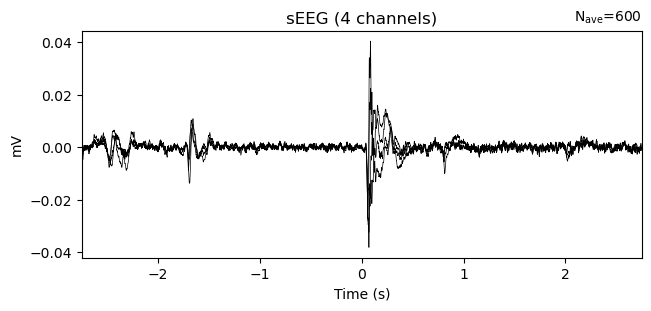

In [23]:
erp = lfp_epochs.average()
erp.plot(picks=['AD01', 'AD02', 'AD03', 'AD04']);

now, the spike rate for one cell in the same time window:

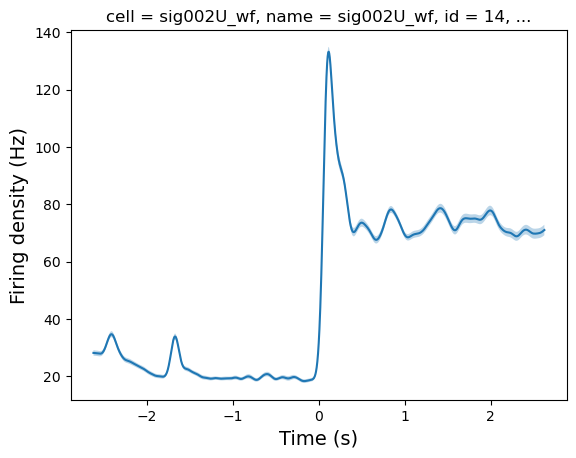

In [31]:
fr = spk_epochs.spike_density(picks=2, fwhm=0.1)
pln.viz.plot_shaded(fr.isel(cell=0));

Note: above we use spike density with a gaussian kernel of full width at half maximum equal to 0.2 seconds (`fwhm=0.2`), but you could also calculate firing rate with a rectangular window, see the example below:

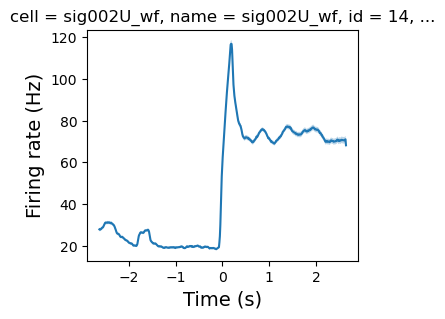

In [37]:
fr2 = spk_epochs.spike_rate(picks=2, winlen=0.25)
fig, ax = plt.subplots(figsize=(3.5, 3))
pln.viz.plot_shaded(fr2.isel(cell=0), ax=ax);

### Create spike-centered windows
We will now take a look at spike-triggered LFP averages in the poststimulus period (from 0.3 seconds post-stimulus).
First we will crop the data to the poststimulus time:

In [38]:
channels = ['AD01', 'AD02', 'AD03', 'AD04']
lfp_poststim = (
    lfp_epochs.copy()
    .crop(tmin=0.3)
    .pick(channels)
)
spk_poststim = spk_epochs.copy().crop(tmin=0.3)

now we create spike-centered windows

In [39]:
lfp_trig = pln.utils.spike_centered_windows(
    spk_poststim, lfp_poststim,
    pick='sig002a_wf', winlen=0.4)

The returned array is of the shape `spikes x channels x timesamples`. The first dimension corresponds to the spikes of the chosen unit from `spk_epochs_correct_prestim` and the last dimension corresponds to timesamples of the timewindow - we chose a `winlen` of `0.4` so `-0.2` and `+0.2` with respect to each spike.

In [40]:
lfp_trig.dims

('spike', 'channel', 'time')

we will also remove the average from each window

In [41]:
lfp_trig -= lfp_trig.mean(dim='time')

### Computing the spike-triggered LFP average
The average of these spike-centered windows is the spike-triggered LFP:

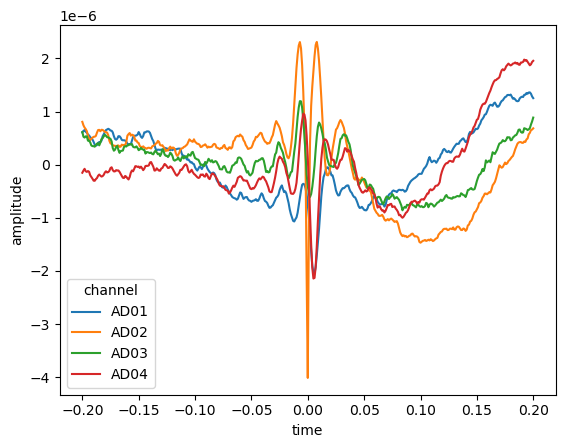

In [42]:
lfp_trig_avg = lfp_trig.mean(axis=0)
lfp_trig_avg.plot(hue='channel')

We can see a nice high-frequency oscillation in the middle suggesting that spike time depends on the phase of that oscillation.  
To plot the average with error intervals (standard error of the mean) we can use `pln.viz.plot_shaded` (but then we have to select one channel):

<Axes: title={'center': 'channel = AD03'}, xlabel='Time', ylabel='Amplitude (V)'>

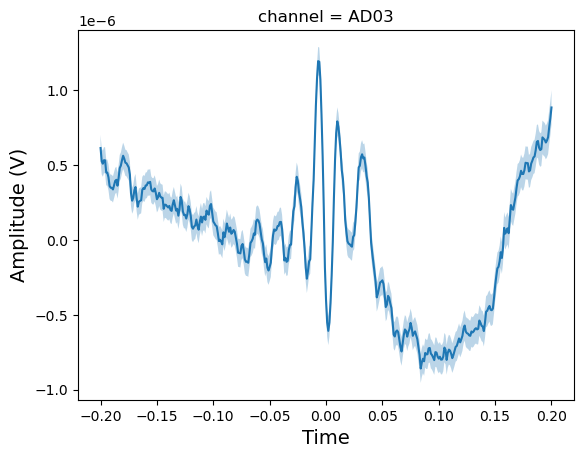

In [43]:
pln.viz.plot_shaded(lfp_trig.sel(channel='AD03'))

### Interpolating the spike artifact

We can see that LFP of channel AD02 displays spike artifact at time 0. This is because the spikes of the unit we used for extracting spike-centered windows were likely detected on this channel, so the LFP still contains some leakage from high-frequency spike events.

<Axes: title={'center': 'channel = AD02'}, xlabel='Time', ylabel='Amplitude (V)'>

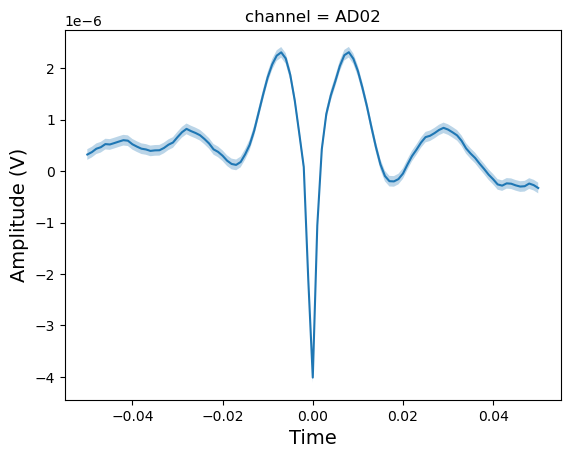

In [44]:
pln.viz.plot_shaded(lfp_trig.sel(channel='AD02', time=slice(-0.05, 0.05)))

To remove the spike artifact we could interpolate the middle samples for this channel before averaging. A common approach is to use linear interpolation but we showcase using a cubic interpolation instead (this may take a couple of seconds as thousands of lines have to be interpolated).

In [45]:
# create a copy to not modify the original signal
lfp_trig_interp = lfp_trig.copy()

# set time close to 0. of channel A02 to np.nan
sel = dict(time=slice(-0.001, 0.001), channel='AD02')
lfp_trig_interp.loc[sel] = np.nan

# interpolate all nan's (in this case - using cubic interpolation) 
lfp_trig_interp = lfp_trig_interp.interpolate_na(
    dim='time', method='cubic')

Compare spike-triggered average before and after interpolation:

<Axes: title={'center': 'channel = AD02'}, xlabel='Time', ylabel='Amplitude (V)'>

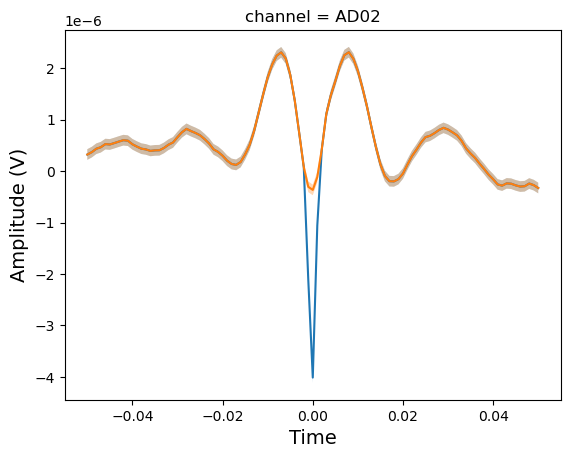

In [46]:
ax = pln.viz.plot_shaded(
    lfp_trig.sel(channel='AD02', time=slice(-0.05, 0.05)),
)
pln.viz.plot_shaded(
    lfp_trig_interp.sel(channel='AD02', time=slice(-0.05, 0.05)),
    ax=ax)

### Comparing conditions
because the spike-triggered LFP xarray inherited all trial-level metadata, we can easily compare conditions now: 

<Axes: title={'center': 'channel = AD03'}, xlabel='Time', ylabel='Amplitude (V)'>

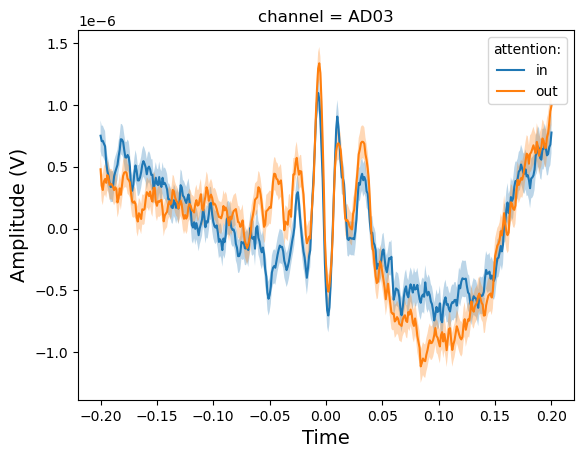

In [47]:
pln.viz.plot_shaded(lfp_trig.sel(channel='AD03'), groupby='attention')

### Compute spike-triggered spectrum
We will use multitaper method to compute spectrum of the spike-centered windows average.

In [48]:
psd, freq = mne.time_frequency.psd_array_multitaper(
    lfp_trig.sel(channel='AD03').mean(dim='spike'),
    sfreq=raw.info['sfreq'], bandwidth=7, fmin=10, fmax=100
)

    Using multitaper spectrum estimation with 2 DPSS windows


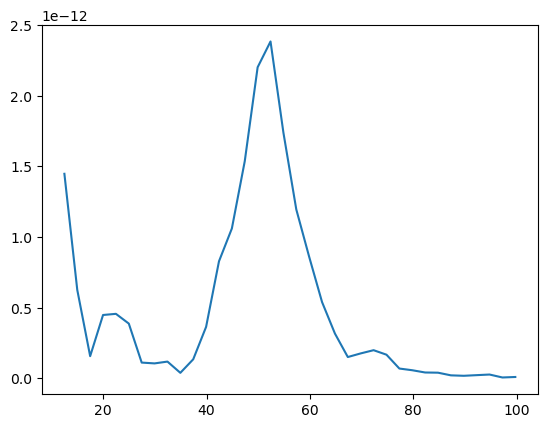

In [49]:
plt.plot(freq, psd)
plt.show()

We see spectral peak around 50 Hz.

### Compare to shuffled data
We will compare the obtained spike-triggered LFP spectrum to one obtained from data where the spike-LFP relationship is abolished by shuffling trials in the spike data (we can either shuffle the LFP or spikes).

In [50]:
new_spk = pln.utils.shuffle_trials(spk_poststim)

In [51]:
lfp_trig_shuff = pln.utils.spike_centered_windows(
    new_spk, lfp_poststim,
    pick='sig002a_wf', winlen=0.4)
lfp_trig_shuff -= lfp_trig_shuff.mean(dim='time')

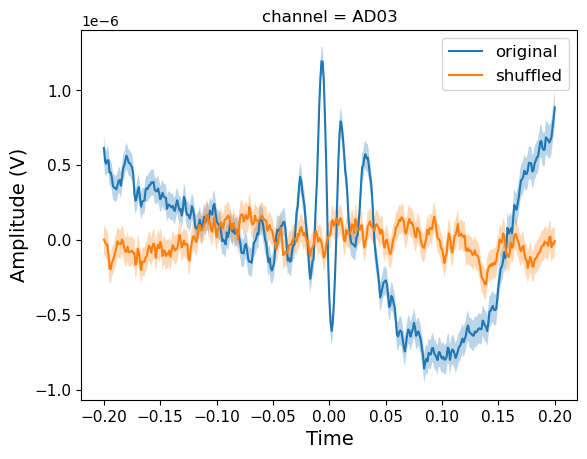

In [52]:
ax = pln.viz.plot_shaded(lfp_trig.sel(channel='AD03'))
pln.viz.plot_shaded(lfp_trig_shuff.sel(channel='AD03'), ax=ax)

# we'll also add legend for line colors and tweak the axis tick a bit:
lines = ax.get_lines()
plt.legend(lines, ['original', 'shuffled'], fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=11)

We cen see that the high-frequency oscillations around time 0 is now absent. Let's show this on the spectrum:

In [53]:
psd_shuff, freq = mne.time_frequency.psd_array_multitaper(
    lfp_trig_shuff.sel(channel='AD03').mean(dim='spike'),
    raw.info['sfreq'], bandwidth=7, fmin=10, fmax=100
)

    Using multitaper spectrum estimation with 2 DPSS windows


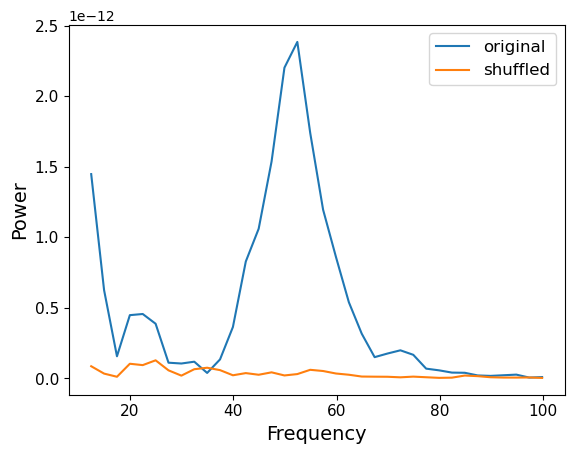

In [54]:
fig, ax = plt.subplots()
plt.plot(freq, psd, label='original')
plt.plot(freq, psd_shuff, label='shuffled')

# we also add line legend and twak the axis ticks and labels
plt.legend(fontsize=12)
ax.set_xlabel('Frequency', fontsize=14)
ax.set_ylabel('Power', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=11)

(we can also see that some lower frequencies are reduced in shuffled data)  
To evaluate the significance of the spike-triggered spectrum we would have to repeat the trial shuffling and spike-triggered LFP generation a few hundred times to generate a null distribution and then compare the original spike-triggered LFP with the null distribution (ideally with a correction for multiple comparisons). This can be done with pylabianca, but for now we leave it as an exercise for the reader.  
  
Hints:  
* set a `n_permutations` variable and use a for loop `for perm_idx in range(n_permutations):`
* in each loop iteration shuffle spike trials, generate spike-triggered windows and calculate the spectrum again
* append the generated spectrum to a `permutations` list
* use `np.stack(permutations, axis=0)` to get a `n_permutations x n_frequencies` array
* finally, use `pylabianca.stats.cluster_based_test_from_permutations` to compare the original spike-triggered spectrum with the null distribution with cluster correction for multiple comparisons.